In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import torch
from torch import nn
from types import SimpleNamespace

import time

from loader import *
from bars import *

In [5]:
DATASET_DIR = 'sample_data/'
DATASET_PREFIX = 'BTCUSD'
MODEL_DIR = 'model/'

In [6]:
params = SimpleNamespace(
    batch_size = 256,
    epochs = 4,
    intraday_freq = '5 min',
    train_date = ('2017-05', '2019-06'),
    valid_date = ('2019-07', '2019-12'),
    test_date  = ('2020-01', '2020-09'),
    sample_date = ('2017-05', '2017-06'),
    modelname = f'{MODEL_DIR}.pt',
    train = True
)

In [7]:
class MeasureTime:
    def __init__(self):
        self.start = time.time()
    def kill(self):
        print ('Time elapsed: ' + time.strftime("%H:%M:%S", time.gmtime(time.time()-self.start)))
        del self

In [8]:
%whos

Variable           Type               Data/Info
-----------------------------------------------
DATASET_DIR        str                sample_data/
DATASET_PREFIX     str                BTCUSD
MODEL_DIR          str                model/
MeasureTime        type               <class '__main__.MeasureTime'>
NamespaceMagics    MetaHasTraits      <class 'IPython.core.magi<...>mespace.NamespaceMagics'>
SimpleNamespace    type               <class 'types.SimpleNamespace'>
add_rolling        function           <function add_rolling at 0x125bd0f28>
add_rolling_bars   function           <function add_rolling_bars at 0x125bd9048>
df_load            function           <function df_load at 0x125bd0d90>
df_read            function           <function df_read at 0x125bd0d08>
get_ipython        function           <function get_ipython at 0x102d5f1e0>
get_tickbars       function           <function get_tickbars at 0x125bd0ea0>
get_timebars       function           <function get_timebars at 0x125bd0e18>

In [9]:
timer = MeasureTime()
df = df_load(DATASET_DIR, DATASET_PREFIX, params.sample_date[0], params.sample_date[1])
timer.kill()
df

Time elapsed: 00:00:00


,ask,bid,ask_volume,bid_volume
date,,,,
2017-05-07 23:59:59.058,1558.6,1555.1,17000,14000
2017-05-07 23:59:59.188,1558.2,1555.2,13000,25000
2017-05-07 23:59:59.324,1557.9,1555.0,9800,4800
2017-05-07 23:59:59.368,1558.2,1555.0,23000,12000
2017-05-07 23:59:59.494,1558.7,1554.7,10000,4200
...,...,...,...,...
2017-05-31 23:59:57.285,2303.7,2301.1,9700,11000
2017-05-31 23:59:57.433,2303.4,2300.4,14000,16000
2017-05-31 23:59:57.680,2303.7,2301.0,6600,5000


In [12]:
df = get_timebars(df, params.intraday_freq)

In [13]:
df

ask                             bid                  \
                        max     min   first    last     max     min   first   
date                                                                          
2017-05-07 23:55:00  1591.3  1557.9  1558.6  1591.3  1590.2  1554.4  1555.1   
2017-05-08 00:00:00  1601.8  1557.6  1557.9  1592.4  1600.7  1551.9  1555.1   
2017-05-08 00:05:00  1602.0  1556.9  1557.0  1591.8  1600.6  1556.3  1556.9   
2017-05-08 00:10:00  1601.6  1562.9  1591.8  1593.2  1601.3  1558.9  1591.3   
2017-05-08 00:15:00  1606.0  1567.3  1593.0  1594.3  1604.6  1564.8  1591.6   
...                     ...     ...     ...     ...     ...     ...     ...   
2017-05-31 23:35:00  2305.1  2299.8  2304.3  2300.6  2301.1  2295.9  2299.9   
2017-05-31 23:40:00  2301.9  2297.8  2300.8  2300.4  2300.8  2296.6  2299.9   
2017-05-31 23:45:00  2301.9  2298.2  2300.2  2298.5  2300.2  2296.8  2297.9   
2017-05-31 23:50:00  2300.8  2293.7  2298.4  2298.6  2299.0  2283.6  2297.5   
2017-05-31 23:55:00  2303.9  2294.3  2298.5  2303.6  2303.4  2294.2  2298.4   

                              spr                 ask_volume bid_volume ticks  
                       last   max  min first last        sum        sum count  
date                                                                           
2017-05-07 23:55:00  1589.9   4.0  0.8   3.5  1.4      121.2      128.0     9  
2017-05-08 00:00:00  1591.1  42.2  0.2   2.8  1.3     8610.8     8648.2   621  
2017-05-08 00:05:00  1591.3  10.1  0.0   0.1  0.5    12319.3    12636.5   906  
2017-05-08 00:10:00  1591.7  30.2  0.0   0.5  1.5     4352.4     4629.3   333  
2017-05-08 00:15:00  1593.2  13.1  0.0   1.4  1.1    12359.8    12324.3   905  
...                     ...   ...  ...   ...  ...        ...        ...   ...  
2017-05-31 23:35:00  2300.0   7.6  0.0   4.4  0.6     4394.5     4289.9   324  
2017-05-31 23:40:00  2297.5   4.3  0.2   0.9  2.9     7040.2     6915.6   513  
2017-05-31 23:45:00  2297.5   4.5  0.0   2.3  1.0    20587.0    20763.6  1511  
2017-05-31 23:50:00  2298.4  11.4  0.0   0.9  0.2     5976.4     6052.2   441  
2017-05-31 23:55:00  2303.4   3.6  0.0   0.1  0.2    16177.9    16229.3  1163  

[4123 rows x 15 columns]

In [19]:
timer = MeasureTime()

In [18]:
timer.kill()

Time elapsed: 00:00:08


In [25]:
tic()
for i in range(10000000):
    pass
toc()

NameError: name 'start' is not defined

In [23]:
tic()

In [28]:
p = ndf[['ask','ask_volume']]
p.columns = p.columns.droplevel()
p = p.rename(columns={'max': 'High', 'min': 'Low', 'first': 'Open', 'last': 'Close', 'sum': 'Volume'})
p

,High,Low,Open,Close,Volume
date,,,,,
2017-05-07 23:55:00,1591.3,1557.9,1558.6,1591.3,121.2
2017-05-08 00:00:00,1601.8,1557.6,1557.9,1592.4,8610.8
2017-05-08 00:05:00,1602.0,1556.9,1557.0,1591.8,12319.3
2017-05-08 00:10:00,1601.6,1562.9,1591.8,1593.2,4352.4
2017-05-08 00:15:00,1606.0,1567.3,1593.0,1594.3,12359.8
...,...,...,...,...,...
2017-05-31 23:35:00,2305.1,2299.8,2304.3,2300.6,4394.5
2017-05-31 23:40:00,2301.9,2297.8,2300.8,2300.4,7040.2
2017-05-31 23:45:00,2301.9,2298.2,2300.2,2298.5,20587.0


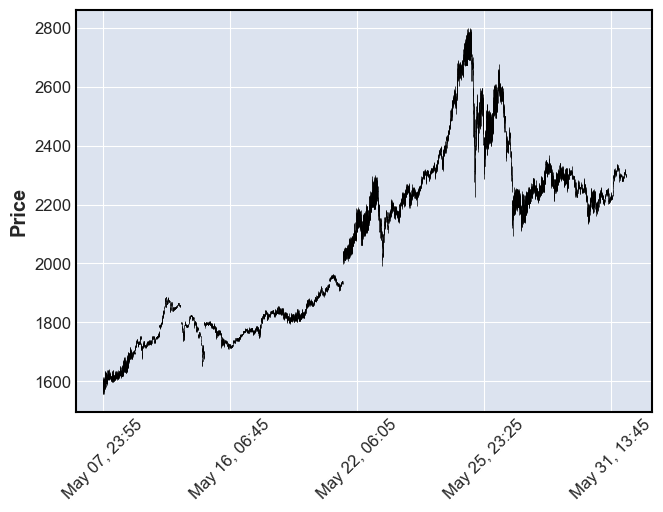

In [29]:
mpf.plot(p)

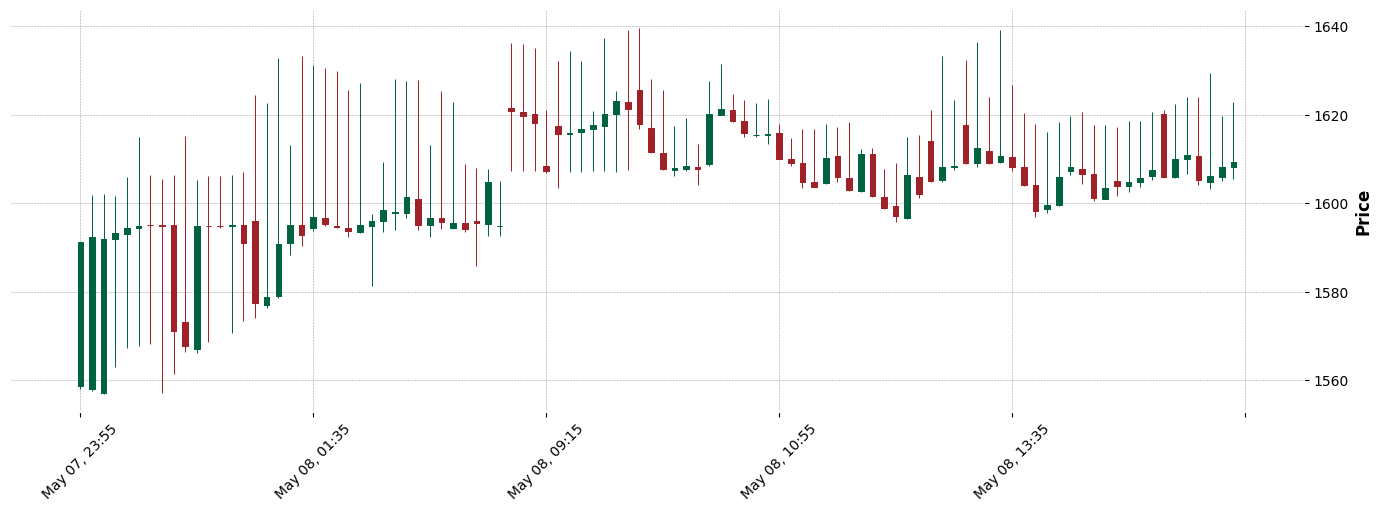

In [44]:
mpf.plot(p.head(100), type='candle', style='charles', figratio=(25,8))

In [58]:
df.head(10)

,ask,bid,ask_volume,bid_volume,spr
date,,,,,
2017-05-07 23:59:59.058,1558.6,1555.1,0.000017,0.000014,3.5
2017-05-07 23:59:59.188,1558.2,1555.2,0.000013,0.000025,3.0
2017-05-07 23:59:59.324,1557.9,1555.0,0.000010,0.000005,2.9
2017-05-07 23:59:59.368,1558.2,1555.0,0.000023,0.000012,3.2
2017-05-07 23:59:59.494,1558.7,1554.7,0.000010,0.000004,4.0
2017-05-07 23:59:59.585,1558.4,1554.4,0.000009,0.000019,4.0
2017-05-07 23:59:59.709,1558.5,1555.2,0.000014,0.000017,3.3
2017-05-07 23:59:59.782,1591.0,1590.2,0.000010,0.000017,0.8
2017-05-07 23:59:59.995,1591.3,1589.9,0.000015,0.000015,1.4


In [65]:
ticks = get_tickbars(df, 9)

In [66]:
ticks

ask                             bid                          spr  \
           max     min   first    last     max     min   first    last  max   
0       1591.3  1557.9  1558.6  1591.3  1590.2  1554.4  1555.1  1589.9  4.0   
1       1558.7  1557.6  1557.9  1557.8  1555.2  1554.4  1555.1  1554.5  3.6   
2       1558.7  1558.0  1558.7  1558.5  1555.3  1554.4  1554.5  1555.2  4.2   
3       1558.6  1557.8  1558.1  1558.6  1555.4  1554.3  1554.3  1554.8  4.1   
4       1590.9  1557.9  1558.3  1558.1  1589.8  1554.3  1555.0  1555.4  4.0   
...        ...     ...     ...     ...     ...     ...     ...     ...  ...   
415339  2303.6  2303.3  2303.3  2303.6  2303.4  2302.8  2303.2  2303.4  0.5   
415340  2303.8  2303.6  2303.7  2303.7  2303.4  2300.1  2300.9  2300.1  3.6   
415341  2303.9  2303.3  2303.3  2303.4  2303.4  2300.4  2301.0  2300.4  3.5   
415342  2303.6  2303.4  2303.6  2303.6  2303.4  2301.0  2303.4  2303.4  2.4   
415343  2303.9  2303.4  2303.9  2303.6  2303.4  2300.4  2300.5  2303.4  3.4   

                                          date                          \
        min first last                   first                    last   
0       0.8   3.5  1.4 2017-05-07 23:59:59.058 2017-05-07 23:59:59.995   
1       2.4   2.8  3.3 2017-05-08 00:00:00.043 2017-05-08 00:00:00.761   
2       2.9   4.2  3.3 2017-05-08 00:00:00.821 2017-05-08 00:00:01.320   
3       2.6   3.8  3.8 2017-05-08 00:00:01.387 2017-05-08 00:00:01.782   
4       1.1   3.3  2.7 2017-05-08 00:00:01.853 2017-05-08 00:00:02.322   
...     ...   ...  ...                     ...                     ...   
415339  0.1   0.1  0.2 2017-05-31 23:59:38.462 2017-05-31 23:59:46.018   
415340  0.2   2.8  3.6 2017-05-31 23:59:46.431 2017-05-31 23:59:48.582   
415341  0.2   2.3  3.0 2017-05-31 23:59:48.730 2017-05-31 23:59:51.946   
415342  0.2   0.2  0.2 2017-05-31 23:59:52.476 2017-05-31 23:59:56.320   
415343  0.2   3.4  0.2 2017-05-31 23:59:56.658 2017-05-31 23:59:57.967   

          ask_volume    bid_volume            date  
                 sum           sum           delta  
0       1.212000e-07  1.280000e-07 00:00:00.937000  
1       1.298000e-07  9.860000e-08 00:00:00.766000  
2       1.076000e-07  1.064000e-07 00:00:00.559000  
3       1.586000e-07  1.560000e-07 00:00:00.462000  
4       1.009000e-07  1.340000e-07 00:00:00.540000  
...              ...           ...             ...  
415339  1.078000e-07  1.323000e-07 00:00:08.707000  
415340  1.184000e-07  1.389000e-07 00:00:02.564000  
415341  1.442000e-07  1.299000e-07 00:00:03.364000  
415342  1.384000e-07  1.135000e-07 00:00:04.374000  
415343  1.202000e-07  1.250000e-07 00:00:01.647000  

[415344 rows x 17 columns]

In [ ]:
params = SimpleNamespace(
    
)